## Creating filelists for training

We will first create filelists of audio on which we wish to finetune the FastPitch model. We will create two kinds of filelists, one which contains only the audio files of the new speaker and one which contains the mixed audio files of the new speaker and the speaker used for training the pre-trained FastPitch Checkpoint.

In [1]:
import random
import os
import json
import torch
import IPython.display as ipd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

data_dir = "/home/pneekhara/Datasets/78419/Hi_Fi_TTS_v_0_backup" # Directory Containing HiFi TTS dataset
filelist_dir = "/home/pneekhara/filelists" # will be created if it does not exist
exp_base_dir = "/home/pneekhara/FinetuningDemo" # will be created if it does not exist


def make_sub_file_list(speaker_id, clean_other, split, num_samples, total_duration_mins, seed=42):
    file_list_name = "{}_manifest_{}_{}.json".format(speaker_id, clean_other, split)
    with open(os.path.join(data_dir, file_list_name), 'r') as f:
        all_records = [json.loads(l) for l in f.read().split("\n") if len(l) > 0]
    for r in all_records:
        r['audio_filepath'] = r['audio_filepath'][r['audio_filepath'].find("wav/"):]
    random.seed(seed)
    random.shuffle(all_records)
    
    if num_samples is not None and total_duration_mins is None:
        sub_records = all_records[:num_samples]
        fname_extension = "ns_{}".format(num_samples)
    elif num_samples is None and total_duration_mins is not None:
        sub_record_duration = 0.0
        sub_records = []
        for r in all_records:
            sub_record_duration += r['duration']
            if sub_record_duration > total_duration_mins*60.0:
                print ("Duration reached {} mins using {} records".format(total_duration_mins, len(sub_records)))
                break
            sub_records.append(r)
        fname_extension = "dur_{}_mins".format( int(round(total_duration_mins )))
    elif num_samples is None and total_duration_mins is None:
        sub_records = all_records
        fname_extension = "ns_all"
    else:
        raise NotImplementedError()
    print ("num sub records", len(sub_records))
    
    if not os.path.exists(filelist_dir):
        os.makedirs(filelist_dir)
    
    target_fp = os.path.join(filelist_dir, "{}_mainifest_{}_{}_local.json".format(speaker_id, split,  fname_extension))
    with open(target_fp, 'w') as f:
        for record in json.loads(json.dumps(sub_records)):
            record['audio_filepath'] = record['audio_filepath'][record['audio_filepath'].find("wav/"):]
            record['audio_filepath'] = os.path.join(data_dir, record['audio_filepath']) 
            f.write(json.dumps(record) + "\n")

def mix_file_list(speaker_id, clean_other, split, num_samples, total_duration_mins, original_speaker_id, original_clean_other, n_orig=None, seed=42):
    file_list_name = "{}_manifest_{}_{}.json".format(speaker_id, clean_other, split)
    with open(os.path.join(data_dir, file_list_name), 'r') as f:
        all_records = [json.loads(l) for l in f.read().split("\n") if len(l) > 0]
    for r in all_records:
        r['audio_filepath'] = r['audio_filepath'][r['audio_filepath'].find("wav/"):]
    
    original_file_list_name = "{}_manifest_{}_{}.json".format(original_speaker_id, original_clean_other, "train")
    with open(os.path.join(data_dir, original_file_list_name), 'r') as f:
        original_all_records = [json.loads(l) for l in f.read().split("\n") if len(l) > 0]
    for r in original_all_records:
        r['audio_filepath'] = r['audio_filepath'][r['audio_filepath'].find("wav/"):]
    
    random.seed(seed)
    if n_orig is not None:
        random.shuffle(original_all_records)
        original_all_records = original_all_records[:n_orig]
        
    random.seed(seed)
    random.shuffle(all_records)
    
    if num_samples is not None and total_duration_mins is None:
        sub_records = all_records[:num_samples]
        fname_extension = "ns_{}".format(num_samples)
    elif num_samples is None and total_duration_mins is not None:
        sub_record_duration = 0.0
        sub_records = []
        for r in all_records:
            sub_record_duration += r['duration']
            if sub_record_duration > total_duration_mins * 60.0:
                print ("Duration reached {} mins using {} records".format(total_duration_mins, len(sub_records)))
                break
            sub_records.append(r)
        fname_extension = "dur_{}_mins".format( int(round(total_duration_mins)))
    elif num_samples is None and total_duration_mins is None:
        sub_records = all_records
        fname_extension = "ns_all"
    else:
        raise NotImplementedError()
        
    print(len(original_all_records))
    
    if not os.path.exists(filelist_dir):
        os.makedirs(filelist_dir)
        
    target_fp = os.path.join(filelist_dir, "{}_mainifest_{}_{}_local_mix_{}.json".format(speaker_id, split,  fname_extension, original_speaker_id))
    with open(target_fp, 'w') as f:
        for ridx, original_record in enumerate(original_all_records):
            original_record['audio_filepath'] = original_record['audio_filepath'][original_record['audio_filepath'].find("wav/"):]
            original_record['audio_filepath'] = os.path.join(data_dir, original_record['audio_filepath']) 
            
            new_speaker_record = sub_records[ridx % len(sub_records)]
            new_speaker_record['audio_filepath'] = new_speaker_record['audio_filepath'][new_speaker_record['audio_filepath'].find("wav/"):]
            new_speaker_record['audio_filepath'] = os.path.join(data_dir, new_speaker_record['audio_filepath']) 
            
            new_speaker_record['speaker'] = 1
            original_record['speaker'] = 0
            f.write(json.dumps(original_record) + "\n")
            f.write(json.dumps(new_speaker_record) + "\n")

In [2]:
make_sub_file_list(92, "clean", "train", None, 5)
mix_file_list(92, "clean", "train", None, 5, 8051, "clean", n_orig=5000)
make_sub_file_list(92, "clean", "dev", None, None)

Duration reached 5 mins using 103 records
num sub records 103
Duration reached 5 mins using 103 records
5000
num sub records 50


## Finetuning the model on filelists

To finetune the FastPitch model on the above created filelists, we use `examples/tts/fastpitch2_finetune.py` script to train the models with either `fastpitch_align_finetuningnomixing.yaml` configuration (for simple finetuning scenario) or `fastpitch_align_finetuningmixing` for finetuning on mixed filelists of new and old speaker. These configuration files have been defined for 44100Hz HiFiGan dataset audio. The function `generate_training_command` in this notebook can be used to generate a training command for a given speaker and finetuning technique.

In [9]:
pitch_stats = {
    92 : {
        'mean' : 214.5,
        'std' : 30.9,
        'fmin' : 80,
        'fmax' : 512
    },
    6097 : {
        'mean' : 121.9 ,
        'std' : 23.1,
        'fmin' : 30,
        'fmax' : 512
    }
}


def generate_training_command(new_speaker_id, duration_mins, mixing_enabled, original_speaker_id, use_new_pitch_stats=False,
                             ckpt = "/home/pneekhara/PreTrainedModels/FastPitch.nemo"):
    
    def _find_epochs(duration_mins, mixing_enabled, n_orig=None):
        # estimated num of epochs 
        if duration_mins == 5:
            epochs = 1000
        elif duration_mins == 30:
            epochs = 300
        elif duration_mins == 60:
            epochs = 150
        
        if mixing_enabled:
            if duration_mins == 5:
                epochs = epochs/50 + 1
            elif duration_mins == 30:
                epochs = epochs/10 + 1
            elif duration_mins == 60:
                epochs = epochs/5 + 1
        
        return int(epochs)
            
            
    if ckpt.endswith(".nemo"):
        ckpt_arg_name = "init_from_nemo_model"
    else:
        ckpt_arg_name = "init_from_ptl_ckpt"
    if not mixing_enabled:
        train_dataset = "{}_mainifest_train_dur_{}_mins_local.json".format(new_speaker_id, duration_mins)
        val_dataset = "{}_mainifest_dev_ns_all_local.json".format(new_speaker_id)
        prior_folder = os.path.join(data_dir, "Priors{}".format(new_speaker_id))
        exp_dir = "{}_to_{}_no_mixing_{}_mins".format(original_speaker_id, new_speaker_id, duration_mins)
        n_speakers = 1
    else:
        train_dataset = "{}_mainifest_train_dur_{}_mins_local_mix_{}.json".format(new_speaker_id, duration_mins, original_speaker_id)
        val_dataset = "{}_mainifest_dev_ns_all_local.json".format(new_speaker_id)
        prior_folder = os.path.join(data_dir, "Priors_{}_mix_{}".format(new_speaker_id, original_speaker_id))
        exp_dir = "{}_to_{}_mixing_{}_mins".format(original_speaker_id, new_speaker_id, duration_mins)
        n_speakers = 2
    train_dataset = os.path.join(filelist_dir, train_dataset)
    val_dataset = os.path.join(filelist_dir, val_dataset)
    exp_dir = os.path.join(exp_base_dir, exp_dir)
                                    
    max_epochs = _find_epochs(duration_mins, mixing_enabled, n_orig=None)
    config_name = "fastpitch_align_finetuning"
    
    training_command = "python examples/tts/fastpitch2_finetune.py --config-name={} train_dataset={} validation_datasets={} +{}={} trainer.max_epochs={} trainer.check_val_every_n_epoch=1 prior_folder={} model.train_ds.dataloader_params.batch_size=24 model.validation_ds.dataloader_params.batch_size=24 exp_manager.exp_dir={} model.n_speakers={}".format(
        config_name, train_dataset, val_dataset, ckpt_arg_name, ckpt, max_epochs, prior_folder, exp_dir, n_speakers)
    if use_new_pitch_stats:
        training_command += " model.pitch_avg={} model.pitch_std={} model.pitch_fmin={} model.pitch_fmax={}".format(
            pitch_stats[new_speaker_id]['mean'], 
            pitch_stats[new_speaker_id]['std'],
            pitch_stats[new_speaker_id]['fmin'],
            pitch_stats[new_speaker_id]['fmax']
        )
        
    return training_command
    

In [10]:
new_speaker_id = 92
duration_mins = 5
mixing = False
original_speaker_id = 8051
print(generate_training_command(new_speaker_id, duration_mins, mixing, original_speaker_id, True))

python examples/tts/fastpitch2_finetune.py --config-name=fastpitch_align_finetuning train_dataset=/home/pneekhara/filelists/92_mainifest_train_dur_5_mins_local.json validation_datasets=/home/pneekhara/filelists/92_mainifest_dev_ns_all_local.json +init_from_nemo_model=/home/pneekhara/PreTrainedModels/FastPitch.nemo trainer.max_epochs=1000 trainer.check_val_every_n_epoch=1 prior_folder=/home/pneekhara/Datasets/78419/Hi_Fi_TTS_v_0_backup/Priors92 model.train_ds.dataloader_params.batch_size=24 model.validation_ds.dataloader_params.batch_size=24 exp_manager.exp_dir=/home/pneekhara/FinetuningDemo/8051_to_92_no_mixing_5_mins model.n_speakers=1 model.pitch_avg=214.5 model.pitch_std=30.9 model.pitch_fmin=80 model.pitch_fmax=512


^ Run the above command from the terminal from the `NeMo/` directory to start finetuning a model. You can adjust the 

## Synthesize samples from finetuned checkpoints

In [5]:
from nemo.collections.tts.models import HifiGanModel
from nemo.collections.tts.models import FastPitchModel

hifigan_ckpt_path = "/home/pneekhara/PreTrainedModels/HifiGan--val_loss=0.08-epoch=899.ckpt"
vocoder = HifiGanModel.load_from_checkpoint(hifigan_ckpt_path)
vocoder.eval().cuda()

/home/pneekhara/miniconda3/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2021-08-17 13:37:42 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text_dali.AudioToCharDALIDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2021-08-17 13:37:42 mode

[NeMo I 2021-08-17 13:37:42 features:252] PADDING: 0
[NeMo I 2021-08-17 13:37:42 features:269] STFT using torch
[NeMo I 2021-08-17 13:37:42 features:271] STFT using exact pad
[NeMo I 2021-08-17 13:37:42 features:252] PADDING: 0
[NeMo I 2021-08-17 13:37:42 features:269] STFT using torch
[NeMo I 2021-08-17 13:37:42 features:271] STFT using exact pad


HifiGanModel(
  (audio_to_melspec_precessor): FilterbankFeatures()
  (trg_melspec_fn): FilterbankFeatures()
  (generator): Generator(
    (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
    (ups): ModuleList(
      (0): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,), padding=(4,))
      (1): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
      (2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(4,))
      (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    )
    (resblocks): ModuleList(
      (0): ModuleList(
        (0): ResBlock1(
          (convs1): ModuleList(
            (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
            (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
          )
          (convs2): ModuleList(
            (0): Conv1d(256,

In [6]:
def infer(spec_gen_model, vocoder_model, str_input, speaker = None):
    parser_model = spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
        if speaker is not None:
            speaker = torch.tensor([speaker]).long().cuda()
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker = speaker)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

def get_best_ckpt(experiment_base_dir, new_speaker_id, duration_mins, mixing_enabled, original_speaker_id):
    if not mixing_enabled:
        exp_dir = "{}/{}_to_{}_no_mixing_{}_mins".format(experiment_base_dir, original_speaker_id, new_speaker_id, duration_mins)
    else:
        exp_dir = "{}/{}_to_{}_mixing_{}_mins".format(experiment_base_dir, original_speaker_id, new_speaker_id, duration_mins)
    
    ckpt_candidates = []
    last_ckpt = None
    for root, dirs, files in os.walk(exp_dir):
        for file in files:
            if file.endswith(".ckpt"):
                val_error = float(file.split("v_loss=")[1].split("-epoch")[0])
                if "last" in file:
                    last_ckpt = os.path.join(root, file)
                ckpt_candidates.append( (val_error, os.path.join(root, file)))
    ckpt_candidates.sort()
    
    return ckpt_candidates, last_ckpt

/home/pneekhara/FinetuningDemo/8051_to_92_no_mixing_5_mins/FastPitch/2021-08-17_13-09-25/checkpoints/FastPitch--v_loss=1.17-epoch=347-last.ckpt


[NeMo W 2021-08-17 13:37:53 modelPT:138] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharWithPriorAndPitchDataset
      manifest_filepath: /home/pneekhara/filelists/92_mainifest_train_dur_5_mins_local.json
      max_duration: null
      min_duration: 0.1
      int_values: false
      normalize: true
      sample_rate: 44100
      trim: false
      sup_data_path: /home/pneekhara/Datasets/78419/Hi_Fi_TTS_v_0_backup/Priors92
      n_window_stride: 512
      n_window_size: 2048
      pitch_fmin: 80
      pitch_fmax: 512
      pitch_avg: 214.5
      pitch_std: 30.9
      vocab:
        notation: phonemes
        punct: true
        spaces: true
        stresses: true
        add_blank_at: None
        pad_with_space: true
        chars: true
        improved_version_g2p: tr

[NeMo I 2021-08-17 13:37:54 features:252] PADDING: 1
[NeMo I 2021-08-17 13:37:54 features:269] STFT using torch
Real validation audio


SYNTHESIZED FOR -- Speaker: 92 | Dataset size: 5 mins | Mixing:False | Text: it was in short the platform of the pillory


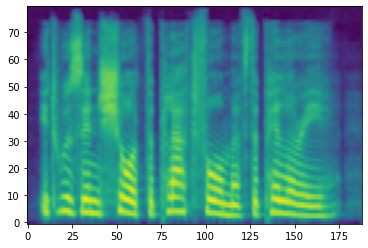

Real validation audio


SYNTHESIZED FOR -- Speaker: 92 | Dataset size: 5 mins | Mixing:False | Text: which


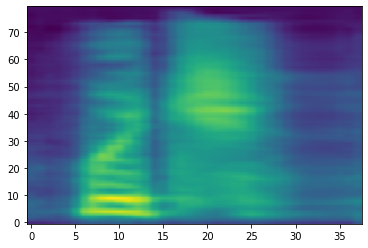

In [8]:
new_speaker_id = 92
duration_mins = 5
mixing = False
original_speaker_id = 8051


_ ,last_ckpt = get_best_ckpt(exp_base_dir, new_speaker_id, duration_mins, mixing, original_speaker_id)
print(last_ckpt)

spec_model = FastPitchModel.load_from_checkpoint(last_ckpt)
spec_model.eval().cuda()
_speaker=None
if mixing:
    _speaker = 1

num_val = 2

manifest_path = os.path.join(filelist_dir, "{}_mainifest_dev_ns_all_local.json".format(new_speaker_id))
val_records = []
with open(manifest_path, "r") as f:
    for i, line in enumerate(f):
        val_records.append( json.loads(line) )
        if len(val_records) >= num_val:
            break
            
for val_record in val_records:
    print ("Real validation audio")
    ipd.display(ipd.Audio(val_record['audio_filepath'], rate=44100))
    print ("SYNTHESIZED FOR -- Speaker: {} | Dataset size: {} mins | Mixing:{} | Text: {}".format(new_speaker_id, duration_mins, mixing, val_record['text']))
    spec, audio = infer(spec_model, vocoder, val_record['text'], speaker = _speaker)
    ipd.display(ipd.Audio(audio, rate=44100))
    %matplotlib inline
    #if spec is not None:
    imshow(spec, origin="lower", aspect = "auto")
    plt.show()